# Coursework 2

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities as gmc
from scipy.stats.stats import pearsonr

## Task 1: Neural Networks

## 1.1 Multi-layer Perceptron

### 1.1.1

The first task is to implement a multi-layer perceptron with a pre-defined architecture. There must be five hidden layers, each with 400 neurons and an output layer with 10 neurons. In addition, the standardised $tanh(x)$ function is the activation function between layers, softmax is the activation function for the output layer. The optimisation used is stochastic gradient descent and our loss function is cross entropy.

For this multi-layer perceptron, we can only use numpy.

Let's load in the data.

In [2]:
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255.
    x_val = x_val.astype('float32') / 255.

    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

(x_train, y_train), (x_val, y_val) = load_data()


Let's check the sizes of each data set are as we would expect.

In [3]:
print('Shape of x_train set: {}'.format(x_train.shape))
print('Shape of y_train set: {}'.format(y_train.shape))
print('Shape of x_val set: {}'.format(x_val.shape))
print('Shape of y_val set: {}'.format(y_val.shape))

Shape of x_train set: (50000, 32, 32, 3)
Shape of y_train set: (50000, 10)
Shape of x_val set: (10000, 32, 32, 3)
Shape of y_val set: (10000, 10)


This is correct. Let's also print some of the images to get an idea of the data we're working with.

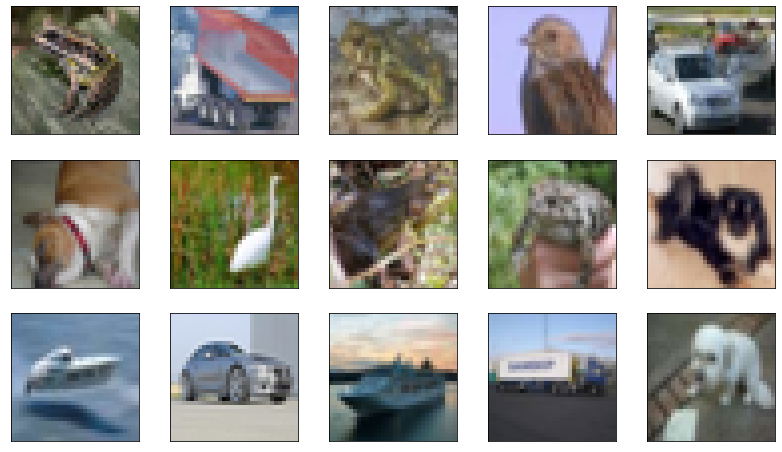

In [4]:
n_rows, n_cols = 3, 5
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

To proceed and create the multi-layer perceptron we need to define a 'dense' function which is responsible for building the hidden layers. Also, we need to define our $tanh(x)$ activation function derivative.

In [5]:
def dense(h, w, b):
    return np.dot(h, w) + b

def dtanh(x):
    return 1 - (np.tanh(x))**2

We also need to define a softmax function for use in the final layer as well as cross-entropy. The cross entropy derivative is a simple subtraction, so there is no need for another function.

In [6]:
def cross_entropy(y, a):
    N = a.shape[0]
    ce = -np.sum(y*np.log(a))/N
    return ce

def softmax(x):
    exp = np.exp(x-np.max(x))
    return exp/(exp.sum(axis=1, keepdims=True))

Below are a series of 'helper' functions for the neural network. I have called them separately to make the code more readable and, as there was no reliance for them to be in the class structure.

Several points of interest, are the backpropagate and grads functions which are similar to code producted in coding task but, I have optimised them by replacing all lines including np.newaxis with matrix multiplication. In addition, by viewing the create_batches function you see that I create 391 batches per epoch, which encompasses the entire data set.

In [7]:
# performs the error at each level of the network
def backpropagate(delta, w, a):
    return dtanh(a)*np.dot(delta, w.T)

# grads function computes the gradients at each iteration
def grads(deltas, post_activations, x_batch):
    # initialise lists
    grad_W = [None]*len(deltas)
    grad_B = [None]*len(deltas)
    for i in range(len(deltas)):
        # I use matrix multiplication instead of np.newaxis as it is far more efficient
        grad_W[i] = np.dot(post_activations[i].T, deltas[i])/(x_batch.shape[0])
        grad_B[i] = np.mean(deltas[i], axis=0)
    return grad_W, grad_B

# accuracy function which takes the y_prediction and true value as its input
def accuracy_nn(y_pred, y_true):
    # find which class is predicted for each instance, this is stored as a list
    class_pred = np.argmax(y_pred, axis=1)
    class_true = np.argmax(y_true, axis=1)
    # compute the accuracy
    acc = sum(1 for x, y in zip(class_pred, class_true) if x == y) / float(len(class_pred))
    return acc

# create batches
def create_batches(x_train, y_train, batch_size):
    # shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]
    x_batches = []
    y_batches = []
    # append lists with batches
    for i in range(int(np.ceil(x_train.shape[0]/batch_size))-1):
            x_batches.append(x_train[i*batch_size:(i+1)*batch_size])
            y_batches.append(y_train[i*batch_size:(i+1)*batch_size])
        
    x_batches.append(x_train[int(np.floor(x_train.shape[0]/batch_size))*batch_size:])
    y_batches.append(y_train[int(np.floor(x_train.shape[0]/batch_size))*batch_size:])

    return x_batches, y_batches

Now, we can build the neural network. I chose to use a class structure for this algorithm as I think it is more readable, useful and concise.

We initialise the algorithm using a list e.g. [100, 50, 50, 2] this is the structure of the layers in the neural network. From this, we give the neural network its class attributes.

Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{3072\times 400}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{400}$

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{400\times 400}$, $k=1,..,5$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{400}$, $k=1,..,5$

Hidden layer -> output layer:
* Kernel $\boldsymbol{W}^{(6)} \in\mathbb{R}^{400\times 10}$
* Bias $\boldsymbol{b}^{(6)} \in\mathbb{R}^{10}$

We initialise the weights using a function which create lists containing the weight matrices for each layer, the are initialised with samples from a zero-mean uniform distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. This initialisation strategy is known as Xavier initialisation. The bias parameters will be initialised to zeros. The other functions are largely self-explanatory. Forward propagation stores the pre-activations and post-activations at each layer in a list, so there is no need to repeat the expensive matrix computation during error calculation. The deltas function computes the deltas as detailed in the lecture notes. Similarly, update_weights is simple.

I chose to create new batches each epoch as adding this additional randomness will result in a model that generalises better: there is a chance that the model could learn the order of the samples in each batch and start to categorise using that information. Adding the additonal shuffling each epoch removes this risk.

In [10]:
class network(object):
    # initialise the network, the variable names are self explanatory
    # sizes is a list of the number of nodes in each layer
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.input_dim = sizes[0]
        self.output_dim = sizes[-1]
        self.hidden_nodes = sizes[1] 
        # this initialises the weights of the model and the model structure, much like sequential does in tensorflow
        self.initialise()
        self.pre_activations=[None]*(len(self.weights)+1)
        self.post_activations=[None]*(len(self.weights)+1)

    # function used to initialise the weights of the model
    def initialise(self):
        self.weights = []
        self.biases = []
        limit = np.sqrt(6/(self.input_dim+self.hidden_nodes))
        # first layer
        self.weights.append(np.random.uniform(-limit, limit, (self.input_dim, self.hidden_nodes)))
        self.biases.append(np.zeros((1, self.hidden_nodes)))

        # hidden layers
        for i in range(self.num_layers-2):
            limit = np.sqrt(3/(self.hidden_nodes))
            self.weights.append(np.random.uniform(-limit, limit, (self.hidden_nodes, self.hidden_nodes)))
            self.biases.append(np.zeros((1, self.hidden_nodes)))

    
        # output layers
        limit = np.sqrt(6/(self.output_dim + self.hidden_nodes))
        self.weights.append(np.random.uniform(-limit, limit, (self.hidden_nodes, self.output_dim)))
        self.biases.append(np.zeros((1, self.output_dim)))
       
    # forward propagation function
    def forward_prop(self, x_batch):
        q = len(self.weights)
        # initialise 
        self.pre_activations[0] = x_batch
        self.post_activations[0] = x_batch

        # compute activations for tanh layers
        for i in range(q-1):
            self.pre_activations[i+1] = dense(self.post_activations[i], self.weights[i], self.biases[i])
            self.post_activations[i+1] = np.tanh(self.pre_activations[i+1])
    
        # compute final activations for the softmax layer
        self.pre_activations[q] = dense(self.post_activations[q-1], self.weights[q-1], self.biases[q-1])
        self.post_activations[q] = softmax(self.pre_activations[q])

    # function to compute the deltas, stored in a list
    def deltas(self, y_batch):
    
        delta_ls = [self.post_activations[-1] - y_batch]
        
        # we will iterate backwards
        for i in range(len(self.pre_activations)-2):
            w = self.weights[-1-i]
            pre = self.pre_activations[-2-i]
            err = backpropagate(delta_ls[-1], w, pre)
            delta_ls.append(err)

        return list(reversed(delta_ls))

    # this function updates the weights
    def update_weights(self, grads, learning_rate):
        grad_W, grad_B = grads
        for i, (dw, db) in enumerate(zip(grad_W, grad_B)):
            self.weights[i] -= learning_rate * dw
            self.biases[i] -= learning_rate * db

    # this function implements the stochastic gradient descent, utilising the prior defined functions
    def sgd(self, x_batch, y_batch, learning_rate):
        self.forward_prop(x_batch)
        delta_ls = self.deltas(y_batch)
        grad_ls = grads(delta_ls, self.post_activations, x_batch)
        self.update_weights(grad_ls, learning_rate)

    # evaluate function computes accuracy and loss when given and x input and true y value
    def evaluate(self, x, y):
        # predictions
        y_pred = self.predict(x)
        # accuracy
        acc = accuracy_nn(y_pred, y)
        # losses
        loss = cross_entropy(y, y_pred)
    
        return acc, loss
    
    # predict function, implements the feedforward processes more efficiently for use in the evaluate function
    def predict(self, a):
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            h = dense(a, w, b)
            a = np.tanh(h)
        h = dense(a, self.weights[-1], self.biases[-1])
        a = softmax(h)
        return a
    
    # the function which train this network
    def train(self, x_train, y_train, x_val, y_val, batch_size, epochs, learning_rate):
        # initialise lists
        train_accs = []
        val_accs = []
        train_losses = []
        val_losses = []

        
        for epoch in range(epochs):
            np.random.seed(5*epoch)
            x_batches, y_batches = create_batches(x_train, y_train, batch_size)
            for i in range(int(np.ceil(x_train.shape[0]/batch_size))):
                # select random batch
                x_batch = x_batches[i]
                y_batch = y_batches[i]
                self.sgd(x_batch, y_batch, learning_rate)
            
            # compute train and validation accuracy and loss
            train_acc, train_loss = self.evaluate(x_train, y_train)
            val_acc, val_loss = self.evaluate(x_val, y_val)

            # update the lists
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        # return dictionary containing values
        return {'train_acc': train_accs, 'val_acc': val_accs, 'train_loss': train_losses, 'val_loss': val_losses}

Let's flatten the input data and train the network, firstly we'll use 40 epochs, a learning rate of 0.01 and a batch size of 128.

In [9]:
# flatten data
x_train_reshape = x_train.reshape(*x_train.shape[:1], -2)
x_val_reshape = x_val.reshape(*x_val.shape[:1], -2)

In [11]:
neural_net = network([3072, 400, 400, 400, 400, 400, 10])
%time history_111 = neural_net.train(x_train_reshape, y_train, x_val_reshape, y_val, 128, 40, 0.01)

Wall time: 12min 21s


As the network has been written in a class structure, given an image we can now call the predict function to see what the model estimates the image to be. Let's print a few examples of this before we plot the accuracy and loss.

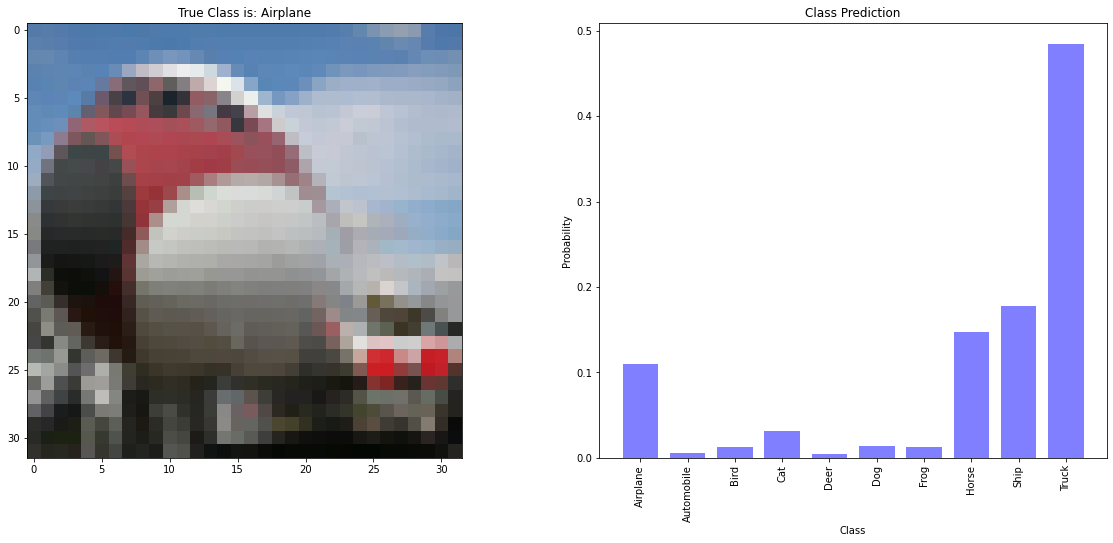

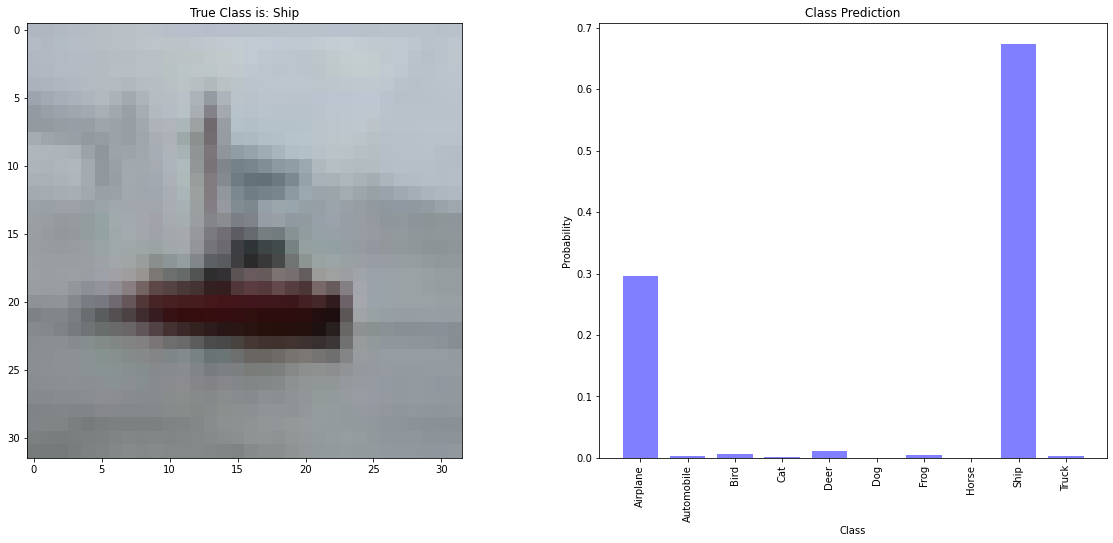

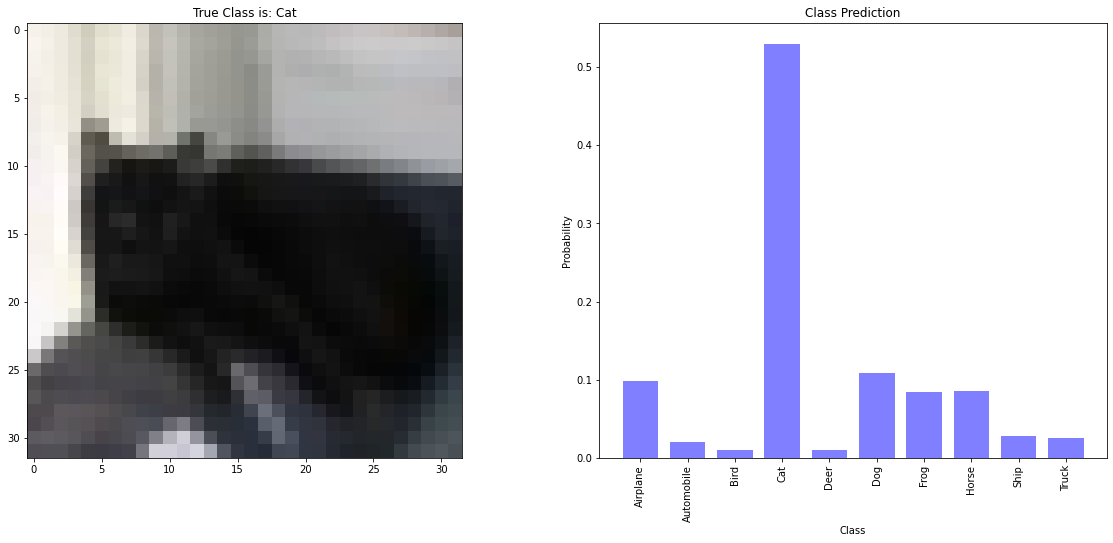

In [86]:
np.random.seed(1)
def network_estimate():
    labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    idx = np.random.randint(0, 49999)
    true_class = np.argmax(y_train[idx])
    plt.imshow(x_train[idx])
    plt.title('True Class is: {}'.format(labels[true_class]))

    plt.subplot(122)
    pred_class = np.squeeze(neural_net.predict(x_train_reshape[idx]))
    idx = range(1, 11)
    x_pos = [2*i for i in idx]
    plt.bar(x_pos, pred_class, width=1.5, color="blue", alpha=0.5)
    plt.xticks(x_pos, labels, rotation='vertical')
    plt.title('Class Prediction')
    plt.xlabel('Class')
    plt.ylabel('Probability')   
    plt.show()
    return

network_estimate()
network_estimate()
network_estimate()

We see the neural network is predicting quite succesfully on distinct images, there is some error but this is to be expected. To get a better understanding of how well the model performed, let's plot the accuracy and loss of the training and validation sets during the training.

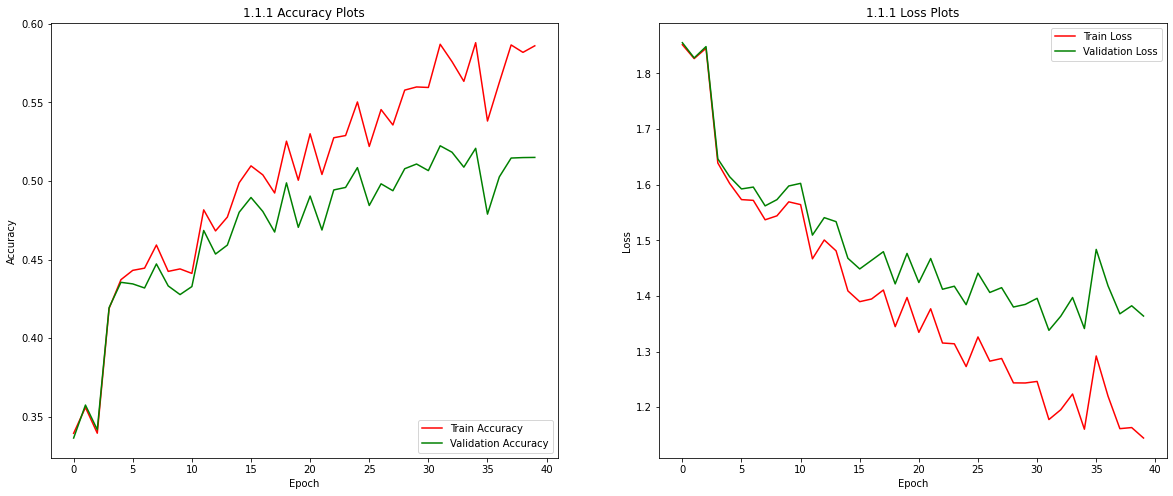

In [92]:
def history_111_plots():
    plt.figure(figsize=(20,8))
    
    plt.subplot(121)
    plt.plot(list(range(40)), history_111['train_acc'], color='r', label='Train Accuracy')
    plt.plot(list(range(40)), history_111['val_acc'], color='green', label='Validation Accuracy')
    plt.title('1.1.1 Accuracy Plots')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(122)
    plt.plot(list(range(40)), history_111['train_loss'], color='r', label='Train Loss')
    plt.plot(list(range(40)), history_111['val_loss'], color='green', label='Validation Loss')
    plt.title('1.1.1 Loss Plots')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return

history_111_plots()

In all cases throughout this question I will print the termination values of loss and accuracy. Due to the class structure I could call the succinct .evaluate() method but as we are returning the values for plotting it made little sense to do so.

In [102]:
print('Termination Training Accuracy is: {}'.format(history_111['train_acc'][-1]))
print('Termination Validation Accuracy is: {}'.format(history_111['val_acc'][-1]))
print('Termination Training Loss is: {}'.format(history_111['train_loss'][-1]))
print('Termination Validation Loss is: {}'.format(history_111['val_loss'][-1]))

Termination Training Accuracy is: 0.58604
Termination Validation Accuracy is: 0.515
Termination Training Loss is: 1.144545619014891
Termination Validation Loss is: 1.363806636730051


From the plots we see what we would expect, an increase in accuracy and decrease in loss during the epochs. Both the validation and accuracy curves are very similar in shape but, the training and validation curves diverge from one another almost immediately. This tells us that there is overfitting. The model appears to be approaching convergence for the validation set as the gradient of the loss curve is approaching zero but, not for the training set.

After 40 epochs, the validation accuracy is around 51.5% and the training accuracy is 58.6%. The validation loss is 1.36 and the training loss is around 1.14.

We see this model took 12 minutes and 21 seconds to train.

### 1.1.2

Lets repeat the process above, but use learning rates of 0.0001 and 0.1.

In [88]:
neural_net = network([3072, 400, 400, 400, 400, 400, 10])
%time history_112 = neural_net.train(x_train_reshape, y_train, x_val_reshape, y_val, 128, 40, 0.0001)

Wall time: 11min 44s


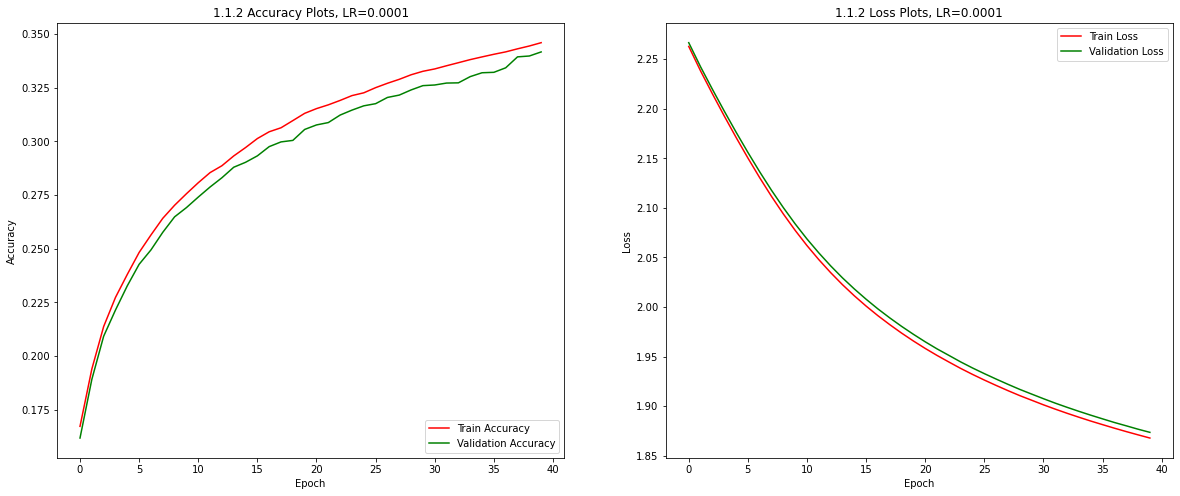

In [93]:
def history_112_plots():
    plt.figure(figsize=(20,8))
    
    plt.subplot(121)
    plt.plot(list(range(40)), history_112['train_acc'], color='r', label='Train Accuracy')
    plt.plot(list(range(40)), history_112['val_acc'], color='green', label='Validation Accuracy')
    plt.title('1.1.2 Accuracy Plots, LR=0.0001')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(122)
    plt.plot(list(range(40)), history_112['train_loss'], color='r', label='Train Loss')
    plt.plot(list(range(40)), history_112['val_loss'], color='green', label='Validation Loss')
    plt.title('1.1.2 Loss Plots, LR=0.0001')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return

history_112_plots()

In [103]:
print('Termination Training Accuracy is: {}'.format(history_112['train_acc'][-1]))
print('Termination Validation Accuracy is: {}'.format(history_112['val_acc'][-1]))
print('Termination Training Loss is: {}'.format(history_112['train_loss'][-1]))
print('Termination Validation Loss is: {}'.format(history_112['val_loss'][-1]))

Termination Training Accuracy is: 0.3459
Termination Validation Accuracy is: 0.3416
Termination Training Loss is: 1.8678440608535014
Termination Validation Loss is: 1.8735795893920186


For the case when the learning rate is 0.0001 we see very explainable results. The learning rate is very small so the model does not train as quickly, we see that both the training and validation curves are very similar; they resemble the first portion of the $0.01$ plots. This is because the model parameters are being updated by much smaller values each time hence, the accuracy increases at a slower rate than the 0.01 case (similar applies to the loss).

We see both curves don't appear to be close to convergence with accuracy terminating at around 35% and the loss around 1.9 for both curves.

We see, the training took 11 minutes and 44 seconds - very close to the 0.01 case.

Now let's train the model for a learning rate of 0.1.

In [95]:
neural_net = network([3072, 400, 400, 400, 400, 400, 10])
%time history_1122 = neural_net.train(x_train_reshape, y_train, x_val_reshape, y_val, 128, 40, 0.1)

Wall time: 12min 57s


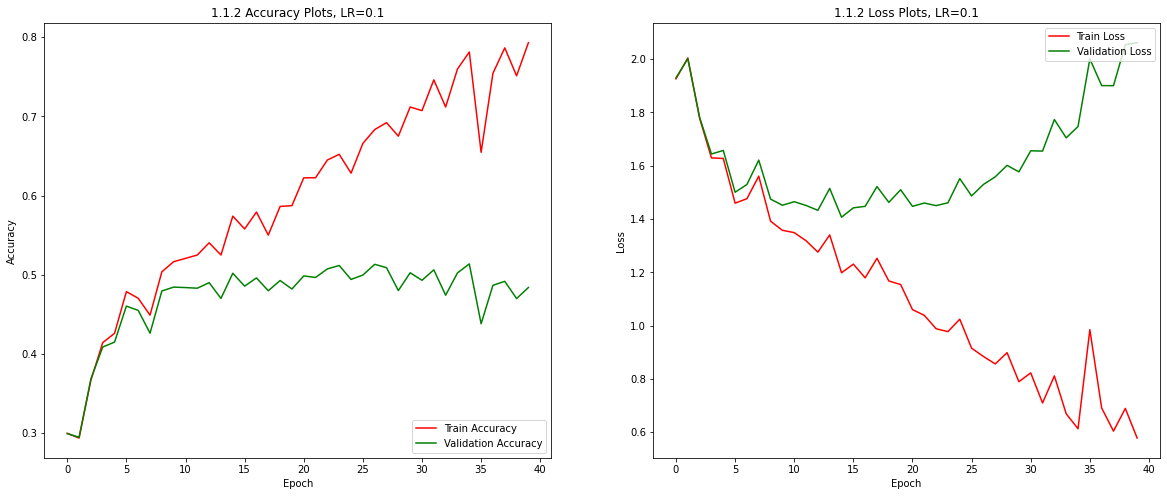

In [97]:
def history_1122_plots():
    plt.figure(figsize=(20,8))
    
    plt.subplot(121)
    plt.plot(list(range(40)), history_1122['train_acc'], color='r', label='Train Accuracy')
    plt.plot(list(range(40)), history_1122['val_acc'], color='green', label='Validation Accuracy')
    plt.title('1.1.2 Accuracy Plots, LR=0.1')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(122)
    plt.plot(list(range(40)), history_1122['train_loss'], color='r', label='Train Loss')
    plt.plot(list(range(40)), history_1122['val_loss'], color='green', label='Validation Loss')
    plt.title('1.1.2 Loss Plots, LR=0.1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return

history_1122_plots()

In [104]:
print('Termination Training Accuracy is: {}'.format(history_1122['train_acc'][-1]))
print('Termination Validation Accuracy is: {}'.format(history_1122['val_acc'][-1]))
print('Termination Training Loss is: {}'.format(history_1122['train_loss'][-1]))
print('Termination Validation Loss is: {}'.format(history_1122['val_loss'][-1]))

Termination Training Accuracy is: 0.79304
Termination Validation Accuracy is: 0.4838
Termination Training Loss is: 0.5781315953836141
Termination Validation Loss is: 2.0614541212643105


The results in the case of 0.1 are very interesting. We see on the accuracy plot that the training and validation curves diverge almost immediately with vast differences between the the curves: training terminates at 79.3% and the validation terminates at 48.4% thus, we have lots of overfitting.

The training accuracy curve shows no sign of converging as the gradient seems linear from epoch 15 onwards. In addition, it is the largest termination value as the values are being updated by larger values each iteration. From epoch 15 onwards in the validation accuracy we see it begins to decrease, this is because at this point, the loss starts increasing again. This is a trademark sign of a learning rate which is too high: the model is overshooting the local minima by updating too drastically each iteration. The loss of the training set decreased with epoch. Training and validation loss terminated at 0.578 and 2.06 respectively.

Training took 12 minutes 57 seconds.

### 1.1.3

For this part, we need to train the model again using a learning rate of 0.01 but, for 80 epochs.

In [96]:
neural_net = network([3072, 400, 400, 400, 400, 400, 10])
%time history_113 = neural_net.train(x_train_reshape, y_train, x_val_reshape, y_val, 128, 80, 0.01)

Wall time: 23min 48s


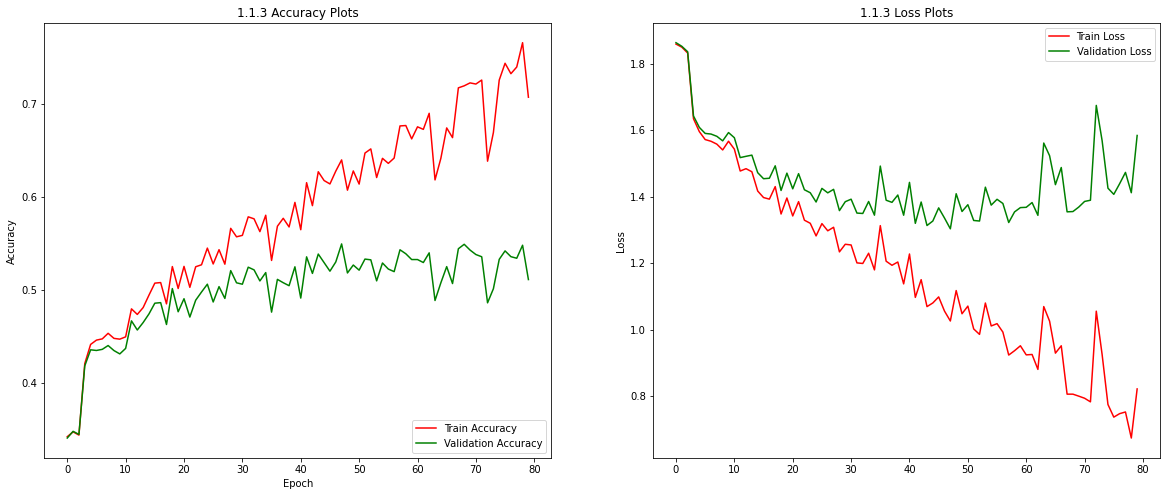

In [99]:
def history_113_plots():
    plt.figure(figsize=(20,8))
    
    plt.subplot(121)
    plt.plot(list(range(80)), history_113['train_acc'], color='r', label='Train Accuracy')
    plt.plot(list(range(80)), history_113['val_acc'], color='green', label='Validation Accuracy')
    plt.title('1.1.3 Accuracy Plots')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(122)
    plt.plot(list(range(80)), history_113['train_loss'], color='r', label='Train Loss')
    plt.plot(list(range(80)), history_113['val_loss'], color='green', label='Validation Loss')
    plt.title('1.1.3 Loss Plots')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return

history_113_plots()

In [105]:
print('Termination Training Accuracy is: {}'.format(history_113['train_acc'][-1]))
print('Termination Validation Accuracy is: {}'.format(history_113['val_acc'][-1]))
print('Termination Training Loss is: {}'.format(history_113['train_loss'][-1]))
print('Termination Validation Loss is: {}'.format(history_113['val_loss'][-1]))

Termination Training Accuracy is: 0.70682
Termination Validation Accuracy is: 0.5109
Termination Training Loss is: 0.8216416103805406
Termination Validation Loss is: 1.5839309151987278


Iterating over 80 epochs at a learning rate of 0.01 should run a very similar model (up to the randomness of the stochastic process) as the 0.01 for 40 epoch model. However, we expect the training accuracy to increase the training loss to decrease during the additional epochs (the training accuracy terminating at 70.7% and loss at 0.823).

We see the training accuracy and loss are not converging however, the validation accuracy is approaching its convergent value: around 50%. This is because the loss of the validation set increases from epoch 40 onwards highlighting why the growth of the accuracy is stunted. Most likely this comes as the model is overfitting.

Comparing to the case where the learning rate is 0.0001 we see there is little use in training with such a small learning rate as it could takes thousands of epochs to get to a similar point as this model which is very time expensive. With the case where the learning rate is 0.1 we see much faster divergence between the training and validation curves thus, it would require much more regularisation to fix.

## 1.2 CNN

It should be mentioned that during this task, where we used TensorFlow I was running GPU TensorFlow $2.3.0$. My PC uses a Ryzen 3600X CPU, RTX 2060 GPU, and 16GB 3200MHz RAM as this will play a large factor when comparing timings later on.

### 1.2.1

For this task I am implementing a neural network using TensorFlow functions. It uses three convolutional layers, two maximum pooling layers, one fully connected layer, and an output layer. The activation function is ReLU for all but the last layer where it is softmax. In addition, the optimiser is stochastic gradient descent. We will be training using a batch size of 128 and a learning rate of 0.1.

Firstly, we need to manipulate the dataset to the correct format for TensorFlow and also initialise our batch method.

In [106]:
# create training data and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# shuffle the dataset
train_dataset = train_dataset.shuffle(buffer_size=1024)
# initialise batch size
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

We can now build our first model using 'Sequential'.

In [138]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# build the model
tfmodel = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


Let's look at the structure of the network using the .summary() method.

In [139]:
tfmodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

These results are as we expect. Now, let's define our optimiser and loss function. Defining them globally makes the code a little more concise and readable later on.

In [140]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

Now we can compile and train the model.

In [141]:
tfmodel.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
%time history = tfmodel.fit(train_dataset, epochs=40, validation_data=val_dataset, verbose=False)

Wall time: 1min 6s


Training has finished, lets produce some plots of the cross entropy loss and accuracy (of the training and validation sets) against the epoch.

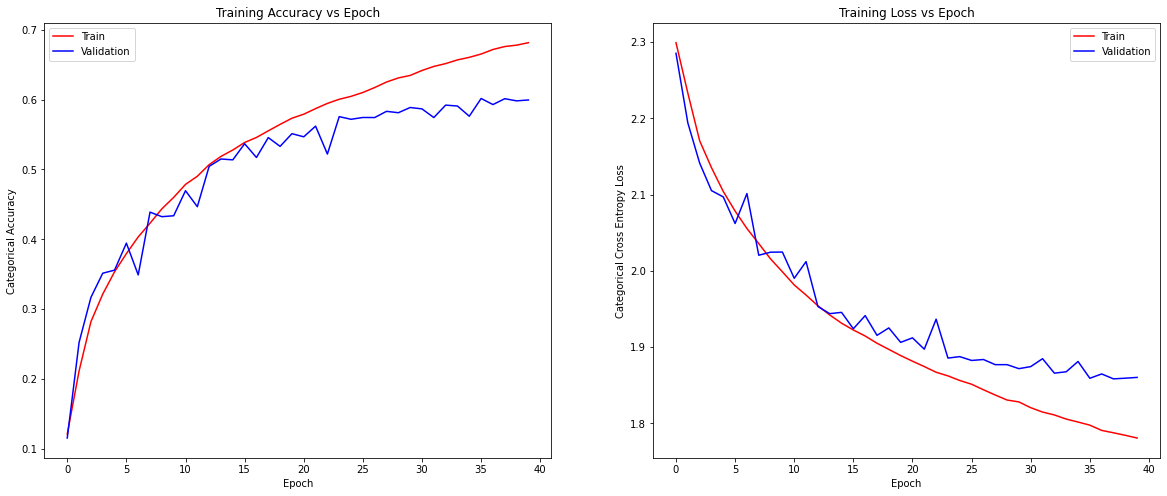

In [142]:
def tfmodel_plots():
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], color='red', label='Train')
    plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Accuracy")
    plt.title("Training Accuracy vs Epoch")
    plt.legend()

    plt.subplot(122)
    plt.plot(history.history['loss'], color='red', label='Train')
    plt.plot(history.history['val_loss'], color='blue', label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Cross Entropy Loss")
    plt.title("Training Loss vs Epoch")
    plt.legend()
    plt.show()
    return

tfmodel_plots()


In [143]:
tfmodel.evaluate(train_dataset)
tfmodel.evaluate(val_dataset)

79/79 [==============================] - 0s 2ms/step - loss: 1.8604 - accuracy: 0.5996


[1.8603943586349487, 0.5996000170707703]

From the plots we see slight overfitting, the training accuracy is 67.8% whereas the validation accuracy terminates at 60.0%. This suggests that if we had some type of regularisation, the model has great potential for accurate predictions of unseen data.

At around epoch 10, we see both plots diverge, the training and validation data splits. With the training accuracy increasing at a faster rate and the training loss decreasing at a faster rate. Once again, this implies there is overfitting.

With regards to convergence, it appears as though the model's training accuracy is far from convergence and could extend to a much greater percentage over more epochs. But, the validation accuracy's growth appears to slow significantly from epoch 25 onwards, this is due to the loss also converging. The losses terminate at around 1.9 and 1.8 for the validation and training sets respectively.

### 1.2.2

For this task, we are implementing the same network as before, but adding l2 regularisation into the convolutional layers.

Below, we create the model.

In [118]:
from tensorflow.keras import regularizers

tfmodel_reg = Sequential([
    Conv2D(32, (3,3), kernel_regularizer=regularizers.l2(5e-3), activation='relu', input_shape=(32, 32, 3)),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(5e-3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(5e-3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

Once again, we summarise.

In [119]:
tfmodel_reg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

Using the same optimiser and loss function as before, we compile and then train the model.

In [120]:
tfmodel_reg.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
%time history_reg = tfmodel_reg.fit(train_dataset, epochs=40, validation_data=val_dataset, verbose=False)

Wall time: 1min 9s


Let's produce some plots of the training and validation accuracy and loss, like before.

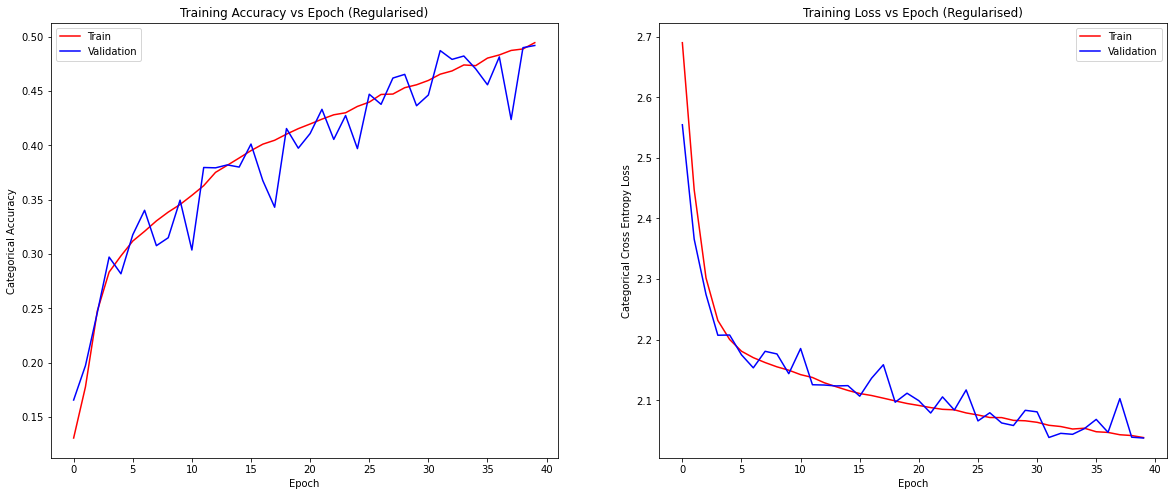

In [121]:
def tfmodel_reg_plots():
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.plot(history_reg.history['accuracy'], color='red', label='Train')
    plt.plot(history_reg.history['val_accuracy'], color='blue', label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Accuracy")
    plt.title("Training Accuracy vs Epoch (Regularised)")
    plt.legend()

    plt.subplot(122)
    plt.plot(history_reg.history['loss'], color='red', label='Train')
    plt.plot(history_reg.history['val_loss'], color='blue', label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Cross Entropy Loss")
    plt.title("Training Loss vs Epoch (Regularised)")
    plt.legend()
    plt.show()
    return

tfmodel_reg_plots()

In [122]:
tfmodel_reg.evaluate(train_dataset)
tfmodel_reg.evaluate(val_dataset)

79/79 [==============================] - 0s 3ms/step - loss: 2.0376 - accuracy: 0.4921


[2.037611484527588, 0.4921000003814697]

These results are very interesting. We see that the training and validation data does not diverge from one another, instead the regularisation has kept the parameters under control and prevented the overfitting. We see an increase in accuracy and a decrease in loss as the number of epochs increase.

However, we also see that the termination accuracy is far lower for both the training and validation data, around 50% and, the loss is much higher at around 2.1 This is most likely due to the fact that the regularisation has 'slowed' down the rate at which the model is training. We see from the plots that neither the training or validation set appears close to convergence so, given more epochs to train, I would expect this model to perform very well.

### 1.2.3

For this question, we once again use the same model but, I must include Dropout of $0.5$ and padding in the convolutional layers. Although padding is not a regulariser in the sense of it penalises parameters, I determined a regulariser to be an implementation which helps the model generalise well. The combination of the padding which increases the number of trainable parameters and the smooth loss function (which I will discuss later) greatly increased the models ability to generalise.

Let's build the model.

In [178]:
from tensorflow.keras.layers import Dropout

tfmodel_custom = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

Now, we can look at the summary.

In [179]:
tfmodel_custom.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 4096)            

I also chose to implement a smooth version of the loss function. This implements 'noise' to the labels, which in essence makes the model 'less confident' when predicting a certain class and in turn reduces overfitting.

In [166]:
smooth_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.01)

Finally, we can compile and train the model.

In [180]:
tfmodel_custom.compile(optimizer=sgd, loss=smooth_loss_fn, metrics=['accuracy'])
%time history_custom = tfmodel_custom.fit(train_dataset, epochs=40, validation_data=val_dataset, verbose=False)

Wall time: 1min 15s


Let's plot!

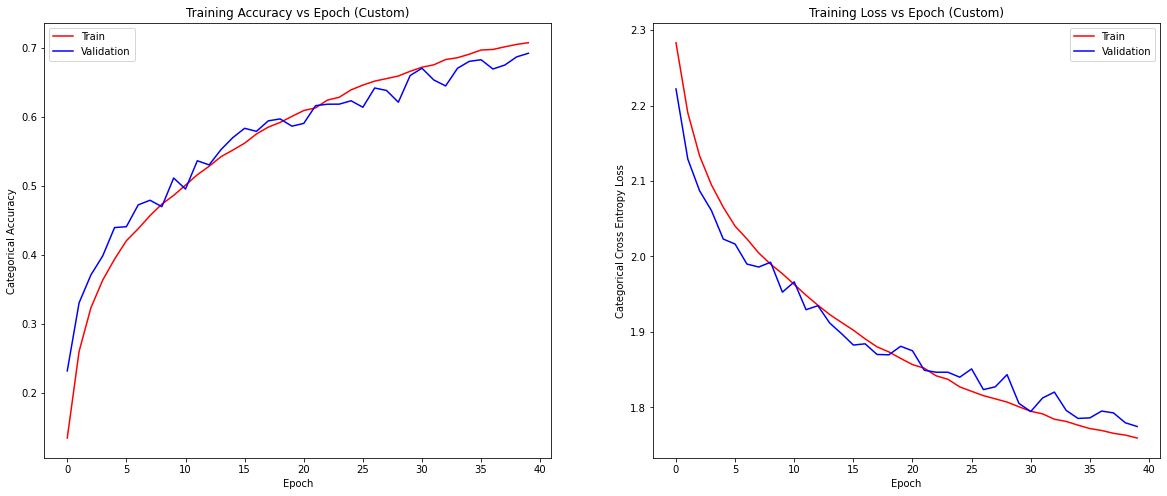

In [181]:
def tfmodel_custom_plots():
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.plot(history_custom.history['accuracy'], color='red', label='Train')
    plt.plot(history_custom.history['val_accuracy'], color='blue', label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Accuracy")
    plt.title("Training Accuracy vs Epoch (Custom)")
    plt.legend()

    plt.subplot(122)
    plt.plot(history_custom.history['loss'], color='red', label='Train')
    plt.plot(history_custom.history['val_loss'], color='blue', label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Cross Entropy Loss")
    plt.title("Training Loss vs Epoch (Custom)")
    plt.legend()
    plt.show()
    return

tfmodel_custom_plots()

This model is the best we have created - within the guidelins - so far. The training and validation accuracy are incresing at almost the same rate, similarly, the loss for both datasets is decreasing at the same rate. The lines on each plot do not diverge from one another in the first 40 epochs, so we have greatly reduced the overfitting which was present in the original model. Comparing to the regularised model in 1.2.2, we see the validation set has far less fluctuation which means the model is generalising better: it is more consistently predicting accurately on unseen data.

With regards to convergence, we terminate at an accuracy of approximately 70% and a loss of 1.75 for both the training and validation data sets. In addition, at this termination point we see the gradient of both curves is far from zero which suggests that if we were to extend the model of more epochs its performance would continue to improve. I was very intruiged to see how the model extended so I trained it on 150 epochs.

In [134]:
tfmodel_custom_long = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

tfmodel_custom_long.compile(optimizer=sgd, loss=smooth_loss_fn, metrics=['accuracy'])
%time history_custom_long = tfmodel_custom_long.fit(train_dataset, epochs=150, validation_data=val_dataset, verbose=False)

Wall time: 4min 41s


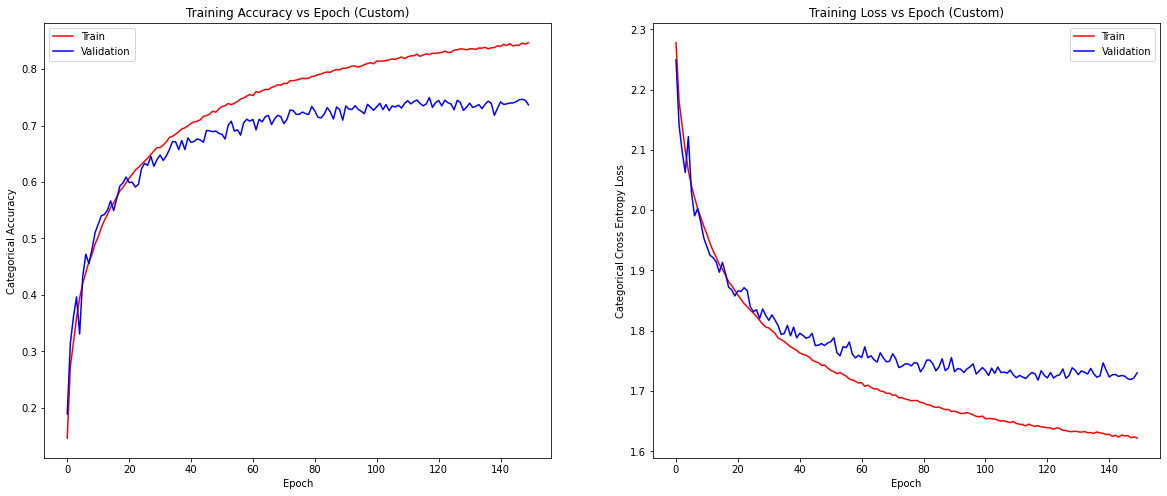

In [135]:
def tfmodel_custom_long_plots():
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.plot(history_custom_long.history['accuracy'], color='red', label='Train')
    plt.plot(history_custom_long.history['val_accuracy'], color='blue', label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Accuracy")
    plt.title("Training Accuracy vs Epoch (Custom)")
    plt.legend()

    plt.subplot(122)
    plt.plot(history_custom_long.history['loss'], color='red', label='Train')
    plt.plot(history_custom_long.history['val_loss'], color='blue', label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Cross Entropy Loss")
    plt.title("Training Loss vs Epoch (Custom)")
    plt.legend()
    plt.show()
    return

tfmodel_custom_long_plots()

In [136]:
tfmodel_custom_long.evaluate(val_dataset)

79/79 [==============================] - 0s 3ms/step - loss: 1.7302 - accuracy: 0.7369


[1.7301677465438843, 0.7368999719619751]

In [137]:
tfmodel_custom_long.evaluate(train_dataset)

391/391 [==============================] - 1s 3ms/step - loss: 1.5792 - accuracy: 0.8900


[1.5792043209075928, 0.8900399804115295]

We see the validation accuracy has plateaued around 74% and of course, the training accuracy is increasing but is currerntly at 89%. Given the restrictions of the task with regards to network structure, I believe this model generalises very well and with minimal changes to the network, it could be even better. Following research online it seems that for a simple model, a validation accuracy of 70% or above is good further confirming that the model is well constructed.

### 1.2.4

For the 40 epoch iterations we have a time of 12 minutes 21 seconds and for the TensorFlow implementation we have a time of 1 minute 15 seconds. Unsurprisingly, the TensorFlow implementation is far more efficient but, only has slightly better accuracy than my implementation. The speed increase is a result of two things, TensorFlow is running rapidly on my GPU whereas Numpy only runs on CPU which is slower and, the TensorFlow backend code will be far more optimised than mine. 

Considering the differnces in computation method we can analyse the effect of the different network structures on time. My Numpy implementation only uses dense layers which take far more parameters than convolution and pooling layers, as can be seen from the summaries I printed earlier. This will once again make my implementation sloweras there is more computation at each iteration.

# Task 2: Unsupervised Learning

## 2.1 Clustering of the Feature Matrix

### 2.1.1

For this task, I am implementing the k-means algorithm with optional parameter '$k$'. I'll be plotting the average within cluster distance for over 100 iterations for $k$ values between 2 and 10.

Firstly however, we need to read in the dataset then convert it to a numpy array. We will also need to remove the first column as it is simply an index.

In [2]:
#read in the data
data = pd.read_csv('feature_matrix_karate_club.csv', sep=',')

In [3]:
# convert data to np.array and remove the first column
F = data.values[:,1:]

Let's print the shape and, the first 5 rows and columns to check the data is in the correct format

In [4]:
print(F[:5, :5])
print(F.shape)

[[ 0.14864008 -0.18710981 -0.10939524  0.11176725 -0.02491311]
 [ 0.20700055 -0.01897949 -0.09448294  0.01342398 -0.10608322]
 [ 0.09396198 -0.26245123 -0.03301012  0.10855057  0.00867919]
 [ 0.21227978 -0.04718743 -0.11648648 -0.00462656  0.02533468]
 [ 0.05365327  0.12233711 -0.13526689 -0.01786216 -0.01221647]]
(34, 100)


Now we can begin the $k$-means algorithm. Firstly, let's create a function to compute the distance between points and centroids.

In [4]:
# function which computes the l2 distance between two points
# computes distances between data points and centroids
def euc_dist_mat(x, centroids):
    return np.array([np.linalg.norm(x-c, axis=1)**2 for c in centroids])

Now, we can build our $k-means algorithm. I added a boolean display argument which prints the percentage change each iteration if it is set to true. Note, the choice to normalise data in $k$-means is subject; in this case, as the data values are all between -1 and 1, I felt as though there was no need. The algorithm works by assigning every point to clusters,then it takes the mean of those clusters (called centroids) and computes which centroid is closests to each data point. We reassign classes to the data points based on their nearest centroid then we repeat the process until convergence.

In [5]:
def kmeans(X, k, epochs=15, display=False):
    # initialise differences if display is true
    if display==True:
        differences = 0
    W_val = 0
    # initialise values
    num_samples, num_features = X.shape
    # initialise labels
    current_labels = np.random.randint(low=0, high=k, size=num_samples)
    new_labels = np.zeros(num_samples)
    # initialise centroids
    centroids = np.zeros((k, num_features))
    for c in range(k):
        if (current_labels == c).any():
            centroids[c] = np.mean(X[current_labels==c], axis=0)
    # iterate through epochs, terminating if the labels are unchanged from the previous iteration
    for i in range(epochs):
        if display==True:
            print('Epoch:', i)
        # create distance matrix
        dist = euc_dist_mat(X, centroids)
        # update labels
        new_labels = np.argmin(dist, axis=0)
        # if labels match, terminate
        if (new_labels==current_labels).all():
            current_labels = new_labels
            if display==True:
                print('Labels unchanged, terminating algorithm')
            # compute the within cluster distance value
            return current_labels, centroids, dist
        # if labels dont match proceed
        else:
            # print percentage change if desired
            if display==True:
                difference = np.mean(current_labels!=new_labels) 
                print('%4f%% labels changed' % (difference * 100))
            # update values of labels
            current_labels = new_labels
            # updating centroid values
            for c in range(k):
                # only update centroid value if there has been a point assigned to that cluster, prevents empty cluster issues
                if (current_labels == c).any():
                    centroids[c] = np.mean(X[current_labels==c], axis=0)
    # compute the within cluster distance value
    return current_labels, centroids, dist


Our data has 100 features per sample, so it is very difficult to visualise whether we are clustering correctly. As a sanity check, I will use a data set from sklearn which can be plotted to ensure the algorithm is working correctly.

In [6]:
from sklearn.datasets import make_blobs
Xblob, _ = make_blobs(n_samples=200, n_features=3, centers=6, random_state=26, center_box=(0, 20))

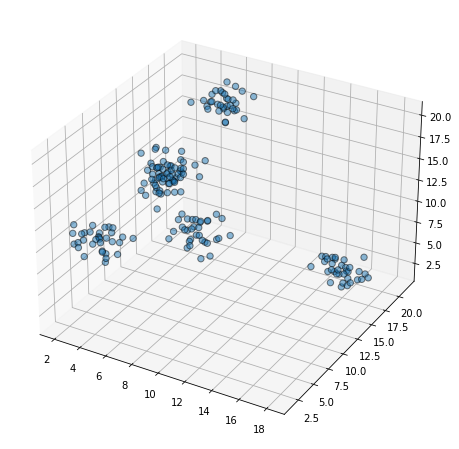

In [15]:
# visualising the clusters
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xblob[:,0],Xblob[:,1],Xblob[:,2], edgecolor='k', s=40, alpha = 0.5)

plt.show()

We would expect 5 groups from this plot, so lets set $k=5$

In [8]:
blob_labels, blob_centroids, _= kmeans(Xblob, 5, display=True)

Epoch: 0
74.000000% labels changed
Epoch: 1
18.000000% labels changed
Epoch: 2
20.500000% labels changed
Epoch: 3
13.000000% labels changed
Epoch: 4
1.000000% labels changed
Epoch: 5
Labels unchanged, terminating algorithm


The algorithm has terminated so let's replot the 'blobs' and color them according to the labels we assigned to ours points via the kmeans algorithm. In addition, I will plot the centroids.

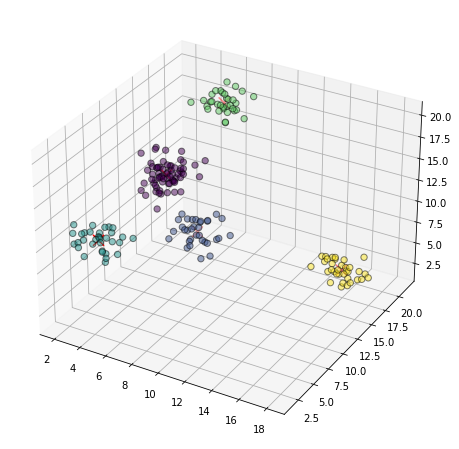

In [16]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xblob[:,0],Xblob[:,1],Xblob[:,2], c=blob_labels, edgecolor='k', s=40, alpha = 0.5)
ax.scatter(blob_centroids[:, 0], blob_centroids[:, 1], blob_centroids[:, 2], c='red', marker='x', s=120);
plt.show()

We see the function has correctly identified the clusters and, the centroids are also in the correct place. So we can be confident that the algorithm is working as we want it to.

For the next part of 2.1.1 we want to perform a type of cross validation to find the optimal value for $k$. To do this, we will run $k$-means 100 times on values of $k$ from 2 to 10. Then plot $k$ against the average within cluster distance across the $100$ repeats.

Below, is a function which implements this - it also returns the average variance of $W$ this is for use in a later question.

In [10]:
def W_cv(X):
    num_samples = X.shape[0]
    kvalues = range(2,11)
    # temporary vector to store the values for the 100 iterations at a given k value
    W_vec = np.zeros(100)
    # vector storing average across the k values
    W_avg = np.zeros(9)
    W_var = np.zeros(9)

    for k in kvalues:
        for i in range(100):
            np.random.seed(5*i)
            W_val = 0 
            labels, _, dist = kmeans(X, k)
            for l in range(num_samples):
                W_val += dist[labels[l], l]
            W_vec[i] = W_val

        avg_value = np.mean(W_vec)
        var_value = np.var(W_vec)
        W_avg[k-2] = avg_value
        W_var[k-2] = var_value
    
    return W_avg, W_var
    
    

In [11]:
W_avg, W_var = W_cv(F)

Let's plot the results of the average.

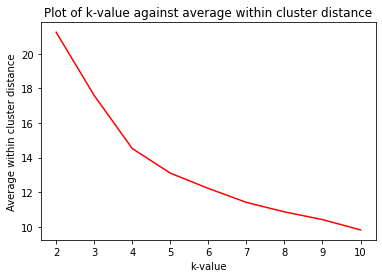

In [12]:
def W_avg_plot():
    plt.plot(range(2,11), W_avg, c='r')
    plt.xlabel('k-value')
    plt.ylabel('Average within cluster distance')
    plt.title('Plot of k-value against average within cluster distance')
    plt.show()
    return

W_avg_plot()

The 'better' a clustering, the lower the value. We see that the average within cluster distance is decreasing as we increase the number of clusters. This is because there are more centroids so, there is a higher chance a given point is closer to a centroid. In addition, there is no discernable 'elbow' where the values decrease more slowly after. As a result of this, I would conjecture that this metric is not a good guide to choose an optimal clustering - mathematically, we can explain why the plot is happening, there is little information gained from the plot.



### 2.1.2

For this task, we had to compute the Calinski-Harabasz Score. This is defined as the ratio of between-clusters dispersion mean and the within cluster dispersion. For a dataset $F$ of size $n_{F}$ which has been clustered into $k$ groups is given by the equation

\begin{equation}\text{CH score} = \frac{\text{tr}(B_k)}{\text{tr}(W_k)} \times \frac{n - k}{k-1}\end{equation}
where
\begin{equation}W_k = \sum_{q=1}^k \sum_{x \in C_q}(x - c_q)(x - c_q)^T\end{equation}
\begin{equation}B_k= \sum_{q=1}^k n_{q}(c_{q}- c_{F})(c_{q}- c_{F})^T\end{equation}

with $C_{q}$ the set of points in cluster $q$, $c_{q}$ the centroid of cluster $q$, $c_{F}$ the center of F and, $n_{q}$ the size of cluster $q$.

Please see [this article](https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c) and [this paper](https://drive.google.com/viewerng/viewer?url=http://datamining.rutgers.edu/publication/internalmeasures.pdf) for more information.

A function to compute this score averaged over 100 random initialisations per $k$ value is below, once again the variance is returned for use in a later question.

In [13]:
def CH_cv(X):
    # initialise values
    num_samples = X.shape[0]
    kvalues = range(2,11)
    CH_vec = np.zeros(100)
    CH_avg = np.zeros(9)
    CH_var = np.zeros(9)

    for k in kvalues:
        for i in range(100):
            np.random.seed(5*i)
            # initialise values in the equation, labelled clearly
            c_F = np.mean(X, axis=0)
            W_k = np.zeros((X.shape[1], X.shape[1]))
            B_k = np.zeros((X.shape[1], X.shape[1]))
            labels, centroids, dist = kmeans(X, k)
            for j in np.unique(labels):
                x = X[labels==j]
                num_pts = len(x)
                c_q = centroids[j]
                W_k += ((x-c_q).T @ (x-c_q))
                B_k += num_pts * ((c_q-c_F).T @ (c_q-c_F))

            # compute score
            CH = (np.trace(B_k)/np.trace(W_k)) * ((num_samples - k)/(k-1))
            # insert value
            CH_vec[i] = CH

        # compute average and insert value
        avg_value = np.mean(CH_vec)
        var_value = np.var(CH_vec)
        CH_avg[k-2] = avg_value
        CH_var[k-2] = var_value
    
    return CH_avg, CH_var
    


In [14]:
CH_avg, CH_var = CH_cv(F)

Let's view the results of the average scores.

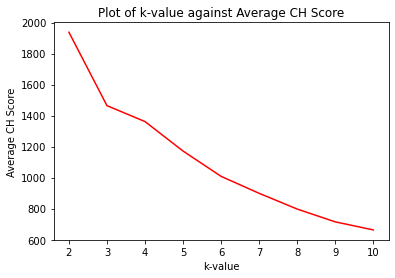

In [15]:
def CH_avg_plot():
    # produce plots
    plt.plot(range(2,11), CH_avg, c='r')
    plt.xlabel('k-value')
    plt.ylabel('Average CH Score')
    plt.title('Plot of k-value against Average CH Score')
    plt.show()
    return

CH_avg_plot()

From reading about the CH score, I am aware that a large score equates to a better clustering. However, I also discovered that if a CH score plot is monotonic or roughly constant then it provides little information about the clusterings. Hence, as this plot is monotonic it does not reveal much insight into the optimal clustering formations. One could argue that $k=2$ is the ideal value as this is the largest result.

### 2.1.3

We want to determine the robustness of the clusterings on this dataset. Ideally, I would like to get an understanding of the variability of the clusterings for each $k$ value. So, I will use the performance measures I have already implemeneted and calculate the variance of the 100 repeats for each $k$ value. Plotting those results should give us a further idea of the variability of each clustering and help us to determine our optimal choice.

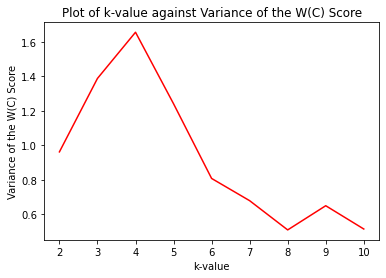

In [16]:
def W_var_plot():
    plt.plot(range(2,11), W_var, c='r')
    plt.xlabel('k-value')
    plt.ylabel('Variance of the W(C) Score')
    plt.title('Plot of k-value against Variance of the W(C) Score')
    plt.show()
    return

W_var_plot()

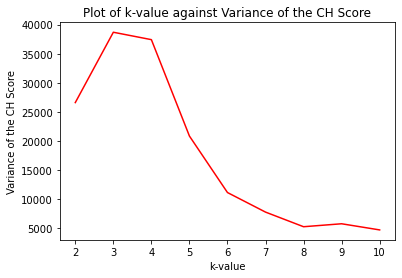

In [17]:
def CH_var_plot():
    plt.plot(range(2,11), CH_var, c='r')
    plt.xlabel('k-value')
    plt.ylabel('Variance of the CH Score')
    plt.title('Plot of k-value against Variance of the CH Score')
    plt.show()
    return

CH_var_plot()

From the two plots we see the average variance of the Within Cluster Distance and CH score across the 9 $k$ values. They both follow a similar pattern of a spike in variance for $k=3$ and $k=4$, this would suggest that there are multiple clusterings being selected for these $k$ values. Hence a lack of consistency there, compared with some of the larger $k$ values. However, it is worth considering that there are only 34 samples so, for the larger $k$ values there is much less likelihood for variability.

Based on the analysis done so far, I believe that kmeans clusterings is not very suitable to determine clusterings of this dataset. For example, there is little to no information able to be gained from the within cluster plot and the CH score plot. In addition, the variances are skewed - most likely due to the inevitable variability that will arise from fewer clusters on such a small data set. The problems arise due to the fact that we have 34 samples and 100 features per sample: it is well known that kmeans does not peform well in high dimensional scenarios. I think a lot more information can be gained by performing dimensionality reduction to the data set and also analysis the adjacency graph.

## 2.2 Dimensionality Reduction of the Feature Matrix

### 2.2.1

We are now going to employ PCA analysis. This process can be broken down into several steps.

1. Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
1. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the spaced spanned by the top $n$ eigenvectors.

Firstly, let's define a function which can normalise a data set.

In [18]:
def normalise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

Now we can build the PCA function. This will return the modified dataset, as well as the sorted eigenvalues and their corresponding eigenvectors.

In [19]:
def pca(X, d):

    X = normalise(X)

    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = eigsh(C, d, which="LM", return_eigenvectors=True)

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

Let's run the PCA and also compute the proportion of variance explained by each principal component.

In [20]:
X_pca, evecs, evals = pca(F, 34)
pc_variance = evals/evals.sum()

To understand how the PCA works lets plot the results in 1, 2 and 3 Dimensions.

In [21]:
def pca_plot1d():
    # 1d
    plt.scatter(X_pca[:,0], np.zeros_like(X_pca[:,0]), c='purple');
    plt.xlabel('Principal Component 1, Variance Explained={}'.format(round(pc_variance[0],3)))
    plt.title('PCA Analysis on the dataset, d=1')
    plt.show()
    return ()

def pca_plot2d():
    # 1d
    plt.scatter(X_pca[:,0], X_pca[:,1], c='purple');
    plt.xlabel('Principal Component 1, Variance Explained={}'.format(round(pc_variance[0],3)))
    plt.ylabel('Principal Component 2, Variance Explained={}'.format(round(pc_variance[1],3)))
    plt.title('PCA Analysis on the dataset, d=2')
    plt.show()
    return ()

def pca_plot3d():
    # 1d
    ax = plt.subplot(111, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c='purple', alpha=1);
    ax.set_xlabel('PC 1, Variance Explained={}'.format(round(pc_variance[0],3)))
    ax.set_ylabel('PC 2, Variance Explained={}'.format(round(pc_variance[1],3)))
    ax.set_zlabel('PC 3, Variance Explained={}'.format(round(pc_variance[2],3)))
    ax.set_title('PCA Analysis on the dataset, d=3')
    plt.show()
    return ()

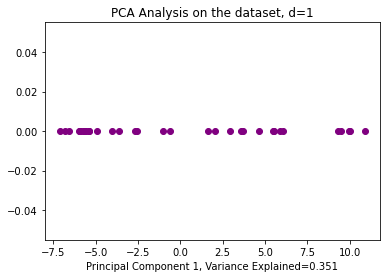

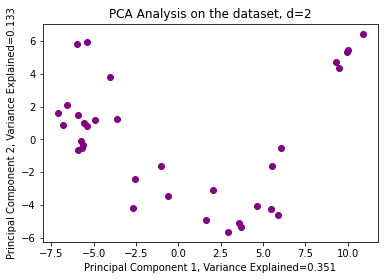

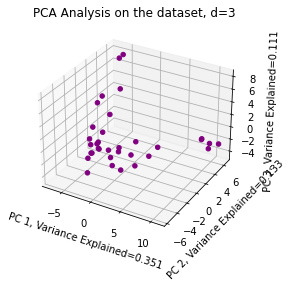

()

In [22]:
pca_plot1d()
pca_plot2d()
pca_plot3d()

From the projections in 1 and 2 dimension we see 3 clear clusterings. So, let's perform kmeans on the dataset, setting $k=3$ and plot the reduced datasets again, using colourings based on these labels.

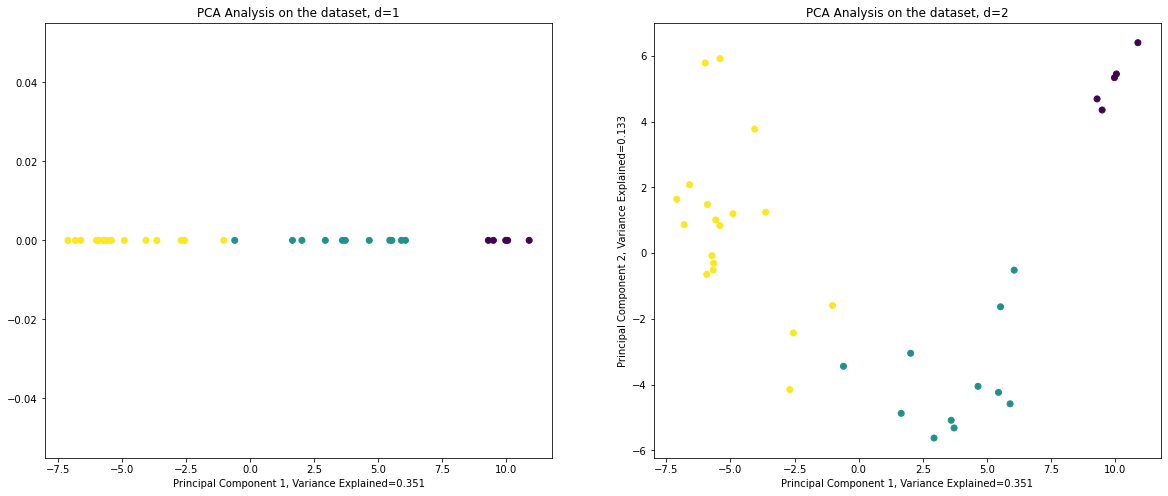

In [81]:
np.random.seed(1)

def pca_plot_color():
    pca_labels, _, _ = kmeans(F, 3)
    # 1d
    plt.figure(figsize=(20,8))

    plt.subplot(121)
    plt.scatter(X_pca[:,0], np.zeros_like(X_pca[:,0]), c=pca_labels);
    plt.xlabel('Principal Component 1, Variance Explained={}'.format(round(pc_variance[0],3)))
    plt.title('PCA Analysis on the dataset, d=1')

    plt.subplot(122)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=pca_labels);
    plt.xlabel('Principal Component 1, Variance Explained={}'.format(round(pc_variance[0],3)))
    plt.ylabel('Principal Component 2, Variance Explained={}'.format(round(pc_variance[1],3)))
    plt.title('PCA Analysis on the dataset, d=2')

    plt.show()
    return


pca_plot_color()

The kmeans algorithm recognises the clusters we see from the dimensionality reduction however, it is worth remebering that there was the most variability in clusterings for the small sizes.

The 3d case is more complex, let's try a range of cluster values and see which visually, appears to fit best.

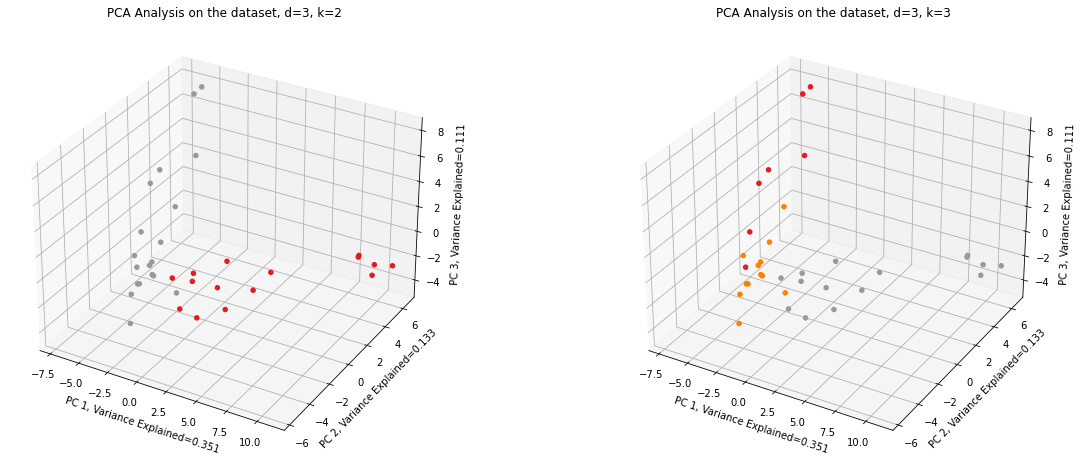

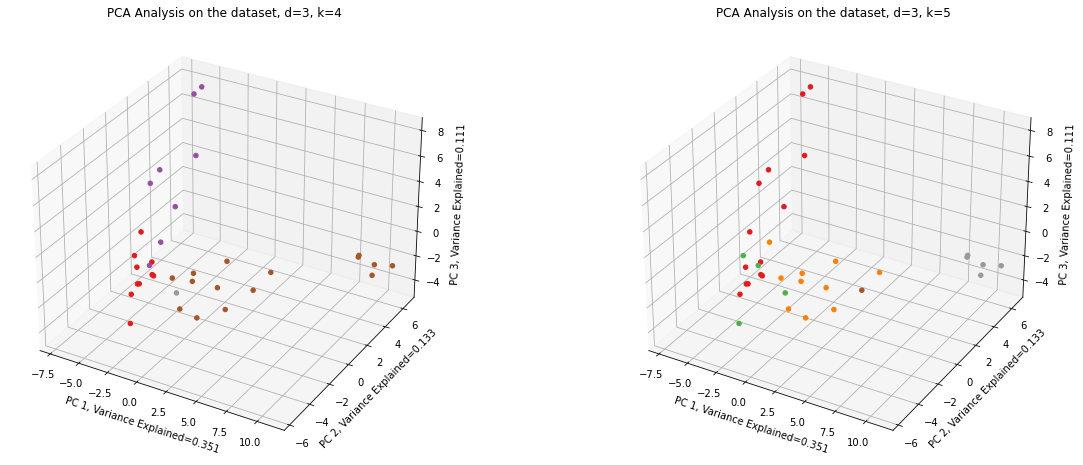

In [9]:
np.random.seed(1)
def pca_color_plot31():

    pca_labels2, _, _ = kmeans(F, 2)
    pca_labels3, _, _ = kmeans(F, 3)

    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=pca_labels2, cmap='Set1', alpha=1);
    ax.set_xlabel('PC 1, Variance Explained={}'.format(round(pc_variance[0],3)))
    ax.set_ylabel('PC 2, Variance Explained={}'.format(round(pc_variance[1],3)))
    ax.set_zlabel('PC 3, Variance Explained={}'.format(round(pc_variance[2],3)))
    ax.set_title('PCA Analysis on the dataset, d=3, k=2')

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=pca_labels3, cmap='Set1', alpha=1);
    ax.set_xlabel('PC 1, Variance Explained={}'.format(round(pc_variance[0],3)))
    ax.set_ylabel('PC 2, Variance Explained={}'.format(round(pc_variance[1],3)))
    ax.set_zlabel('PC 3, Variance Explained={}'.format(round(pc_variance[2],3)))
    ax.set_title('PCA Analysis on the dataset, d=3, k=3')

    

    plt.show()

    return

def pca_color_plot32():
    pca_labels4, _, _ = kmeans(F, 4)
    pca_labels5, _, _ = kmeans(F, 5)
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=pca_labels4, cmap='Set1', alpha=1);
    ax.set_xlabel('PC 1, Variance Explained={}'.format(round(pc_variance[0],3)))
    ax.set_ylabel('PC 2, Variance Explained={}'.format(round(pc_variance[1],3)))
    ax.set_zlabel('PC 3, Variance Explained={}'.format(round(pc_variance[2],3)))
    ax.set_title('PCA Analysis on the dataset, d=3, k=4')

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=pca_labels5, cmap='Set1', alpha=1);
    ax.set_xlabel('PC 1, Variance Explained={}'.format(round(pc_variance[0],3)))
    ax.set_ylabel('PC 2, Variance Explained={}'.format(round(pc_variance[1],3)))
    ax.set_zlabel('PC 3, Variance Explained={}'.format(round(pc_variance[2],3)))
    ax.set_title('PCA Analysis on the dataset, d=3, k=5')

pca_color_plot31()
pca_color_plot32()

Interstingly, when we move to 3 dimensions, it appears as though $k=2$ and $k=3$ provided certainly more obvious clusterings. For $k\geq 4$ there is little discernable structure, this leads us to believe that the aforementioned clusterings are more natural and more likely to be optimal.

### 2.2.2

For this part, I need to plot the proportion of explained variance by each eigenvalue.

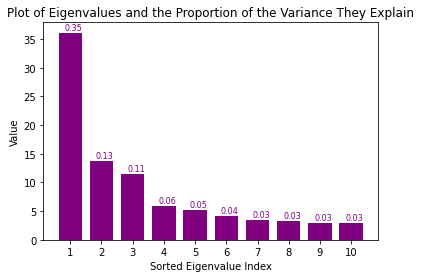

In [19]:
def pca_var_plot():
    idx = range(1,11)
    x_pos = [2*j for j in idx]   
    plt.bar(x_pos, evals[:10], width=1.5, color="purple")
    plt.xticks(x_pos, idx)
    plt.title('Plot of Eigenvalues and the Proportion of the Variance They Explain')
    plt.xlabel('Sorted Eigenvalue Index')
    plt.ylabel('Value')
    for i in idx:
        plt.text(2*i-.35, evals[i-1]+.5, str(round(pc_variance[i-1],2)), color='purple', fontsize=8)      
    plt.show()
    return 

pca_var_plot()

Looking at the plot in this section, the first eigenvalue explains a vastly larger portion of the variance that all of the others. As a result of this, we would expect that the dataset is reasonably well described in a reduced dimension. However, despite the larger value, the proportion of variance explained by the largest eigenvalue is only 0.35 which is not a majority. We need to consider this when performing analysis of datasets as this could cause misleading results. For example, if we used the first three principal compoenents, this accounts for 0.35+0.13+0.11=0.59 of the variance. This is over half, but there is still a considerable amount missing and this missing information could be very important.

## 2.3 Graph-based Analysis

Firstly, let's read in the numpy array which represents the graph and remove the first indexing column.

In [2]:
# read data
karate_data = pd.read_csv('karate_club_graph.csv', sep=',')

In [3]:
# remove index column
karate_G = karate_data.values
karate_G = karate_G[:,1:]

### 2.3.1 Centralities

For this task, we are computing centralities: degree, eigenvector and PageRank using only NumPy/SciPy. 

Firstly, we'll compute the degree centrality.
$$ c_{d} = \frac{d}{N-1} = \frac{A1}{N-1}$$ where $N$ is the number of vertices and $A$ is the adjacency matrix. This definition is different to the one given in lectures up to multiplication by a scalar but, I chose to use this one as it is the same as networkx which is useful to check it is correct.

In [4]:
def deg_centrality(A):
    # number of vertices
    N = A.shape[0]
    # compute d
    d = A @ np.ones(N)

    # compute centrality
    cd = d/(N-1)

    return cd

Next, we compute the eigenvector centrality. This value is equivalent to the eigenvector of the adjacency matrix ($A$), correspoding to the largest eigenvalue.

In [5]:
def eig_centrality(A):
    # find leading eigenvector
    evals, evecs = np.linalg.eigh(A)
    # find largest
    idx = np.argmax(evals)
    ce = np.squeeze(evecs[:,idx])
    return ce

Finally, a PageRank function: the algorithm which was pioneered by the founders of Google. It is defined by the following iterative formula
$$
c_{\text{PR}_{t+1}} = \alpha (AD^{-1})c_{\text{PR}_{t}} + (1-\alpha)\frac{1}{N}
$$
where $A$ is the adjencency matrix, $D$ is the diagonal matrix with the degree of each node on the diagonal and $N$ is the number of vertices. $\alpha$ is an adjustable hyperparameter usually set to 0.85.

In [6]:
def PageRank(A, num_iterations=100, alpha=0.85, tol=1e-6):
    N = A.shape[0]
    keys = range(N)
    err = 1
    # initialise cpr
    c_old = 1/N * np.ones(N)
    c_new = np.ones(N)
    # initialise D
    d =  A @ np.ones(N)
    D = np.diag(d)
    ADinv = A @ np.linalg.inv(D)
    # iterative step
    for _ in range(num_iterations):
        c_new = alpha*(ADinv @ c_old) + (1-alpha)/N
        err = np.linalg.norm(c_new - c_old, ord=1)
        # check if we have reached the tolerance (set based on networkx guidelines)
        if err < tol:
            return c_new
        else:
            c_old = c_new

    return c_new

Let's compute the values for our graph.

In [7]:
cd = deg_centrality(karate_G)
ce = eig_centrality(karate_G)
cpr = PageRank(karate_G)

In [140]:
print('Degree Centralities: \n{}'.format(cd))

Degree Centralities: 
[0.48484848 0.27272727 0.3030303  0.18181818 0.09090909 0.12121212
 0.12121212 0.12121212 0.15151515 0.06060606 0.09090909 0.03030303
 0.06060606 0.15151515 0.06060606 0.06060606 0.06060606 0.06060606
 0.06060606 0.09090909 0.06060606 0.06060606 0.06060606 0.15151515
 0.09090909 0.09090909 0.06060606 0.12121212 0.09090909 0.12121212
 0.12121212 0.18181818 0.36363636 0.51515152]


In [141]:
print('Eigenvector Centralities: \n{}'.format(ce))

Eigenvector Centralities: 
[0.35549144 0.26595992 0.3171925  0.21117972 0.07596882 0.07948305
 0.07948305 0.17095975 0.22740391 0.10267425 0.07596882 0.0528557
 0.08425463 0.22647272 0.10140326 0.10140326 0.02363563 0.09239954
 0.10140326 0.14791251 0.10140326 0.09239954 0.10140326 0.15011857
 0.05705244 0.05920647 0.07557941 0.13347715 0.13107782 0.13496082
 0.1747583  0.19103384 0.30864422 0.37336347]


In [142]:
print('PageRank: \n{}'.format(cpr))

PageRank: 
[0.09699751 0.05287698 0.0570785  0.03585991 0.02197805 0.0291113
 0.0291113  0.02449053 0.02976604 0.01430938 0.02197805 0.00956476
 0.01464492 0.02953648 0.01453597 0.01453597 0.01678409 0.0145587
 0.01453597 0.01960465 0.01453597 0.0145587  0.01453597 0.03152243
 0.02107599 0.02100615 0.015044   0.02563972 0.01957343 0.02628847
 0.02459013 0.03715803 0.07169303 0.10091894]


Let's check these values are correct, by comparing to functions built in to networkx.

In [127]:
cd2 = np.array(list(nx.degree_centrality(nx.from_numpy_matrix(karate_G)).values()))
ce2 = np.array(list(nx.eigenvector_centrality(nx.from_numpy_matrix(karate_G)).values()))
cpr2 = np.array(list(nx.pagerank(nx.from_numpy_matrix(karate_G)).values()))

In [130]:
print('The statement, "The Degree Centrality function is correct" is {}'.format(np.allclose(cd, cd2, atol=1e-5)))
print('The statement, "The Eigenvector Centrality function is correct" is {}'.format(np.allclose(ce, ce2, atol=1e-5)))
print('The statement, "The PageRank function is correct" is" {}'.format(np.allclose(cpr, cpr2, atol=1e-5)))

The statement, "The Degree Centrality function is correct" is True
The statement, "The Eigenvector Centrality function is correct" is True
The statement, "The PageRank function is correct" is" True


We see all functions are working correctly. To study which nodes are highly central, I will produce plots of the graph using networkx and colour according to the centrality/rank value.

Lets plot!

In [8]:
# convert graph to networkx format
np.random.seed(4) # I like how the nodes are placed visually with this seed
karate_nx = nx.from_numpy_matrix(karate_G)
pos = nx.spring_layout(karate_nx)

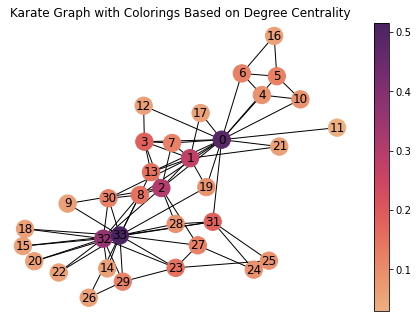

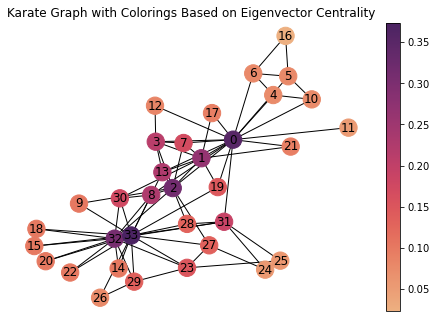

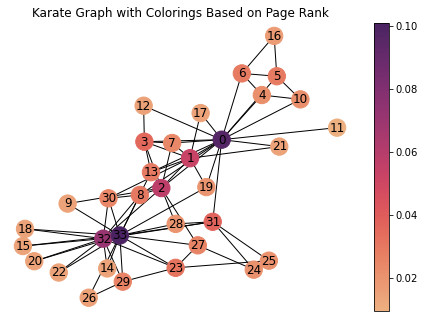

In [20]:
#draw graph with colours based on scores.
def graph_cd():
    nx.draw(karate_nx, pos, nodelist=karate_nx.nodes(), with_labels=True, node_color=cd, cmap='flare')
    sm = plt.cm.ScalarMappable(cmap='flare', norm=plt.Normalize(vmin = min(cd), vmax=max(cd)))
    plt.colorbar(sm)
    plt.title('Karate Graph with Colorings Based on Degree Centrality')
    plt.show()
    return

def graph_ce():
    nx.draw(karate_nx, pos, nodelist=karate_nx.nodes(), with_labels=True, node_color=ce, cmap='flare')
    plt.title('Karate Graph with Colorings Based on Eigenvector Centrality')
    sm = plt.cm.ScalarMappable(cmap='flare', norm=plt.Normalize(vmin = min(ce), vmax=max(ce)))
    plt.colorbar(sm)
    plt.show()
    return

def graph_cpr():
    nx.draw(karate_nx, pos, nodelist=karate_nx.nodes(), with_labels=True, node_color=cpr, cmap='flare')
    plt.title('Karate Graph with Colorings Based on Page Rank')
    sm = plt.cm.ScalarMappable(cmap='flare', norm=plt.Normalize(vmin = min(cpr), vmax=max(cpr)))
    plt.colorbar(sm)

    plt.show()
    return

graph_cd()
graph_ce()
graph_cpr()

We see lots of similarities between the plots: nodes 0, 1, 32 and 33 are highly central accordingly to all three metrics, they are the darkest shades on all plots. Degree Centrality and PageRank appear to be very similar, we see almost all nodes have exactly the same colourings. Howvever, it appears that the eigenvector rank produces a greater distribution of weightings across the nodes. The Degree Centrality and PageRank are so similar as they assign weights based on the number edges connected to each vertex whereas, the Eigenvector Centrality assigns higher centrality to nodes are themselves connected to highly central nodes. This explains the difference, as the graphs have a few highly connected nodes givingthe extreme values present in Degree Centrality and PageRank but, there are several nodes connected to these highly central ones: providing the intermediate values present in the Eigenvector Centrality.

To continue this exploration further, let's look at the correlation/similarity between rankings. To do this, I will plot Node number against the rankings for each measure (while the values will range, we can view the shape of the graphs). I will also explicity calculate the pearson correlation coefficient between the rankings. We expect - based on previous analysis - that there will be high correlation between all rankings but, extremely high between degree and PageRank.

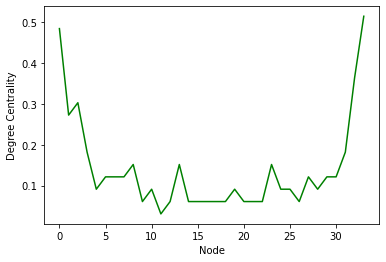

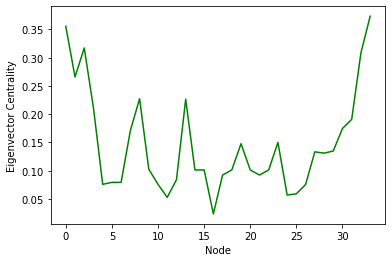

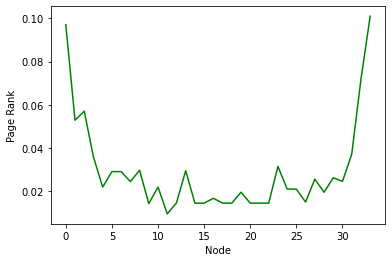

In [21]:
# plots
def graph_value_plots_cd():
    plt.plot(range(len(cd)), cd, c='g')
    plt.xlabel('Node')
    plt.ylabel('Degree Centrality')
    plt.show()
    return

def graph_value_plots_ce():
    plt.plot(range(len(ce)), ce, c='g')
    plt.xlabel('Node')
    plt.ylabel('Eigenvector Centrality')
    plt.show()
    return
  
def graph_value_plots_cpr():
    plt.plot(range(len(cpr)), cpr, c='g')
    plt.xlabel('Node')
    plt.ylabel('Page Rank')
    plt.show()
    return

graph_value_plots_cd()
graph_value_plots_ce()
graph_value_plots_cpr()

In [182]:
# computing correlation
cd_vs_ce = pearsonr(cd, ce)
cd_vs_cpr = pearsonr(cd, cpr)
ce_vs_cpr = pearsonr(ce, cpr)

In [184]:
print('Pearson Correlation between Degree and Eigenvector Centrality is {}'.format(cd_vs_ce))
print('Pearson Correlation between Degree Centrality and PageRank is {}'.format(cd_vs_cpr))
print('Pearson Correlation between Eigenvector Centrality and PageRank is {}'.format(ce_vs_cpr))

Pearson Correlation between Degree and Eigenvector Centrality is (0.917254628323356, 2.4427600277755324e-14)
Pearson Correlation between Degree Centrality and PageRank is (0.9979044040029161, 1.2501044487331988e-39)
Pearson Correlation between Eigenvector Centrality and PageRank is (0.8919283311752442, 1.4530498078170075e-12)


As expected, all three measures are similar, this is evident by the correlation of $ \geq 0.89$ and $p$-values of $ \leq 1.45\text{x}10^{-12}$. In addition, we see striking similarities between the Degree Centrality and PageRank, the two plots are almost identical in shape and it requires really close analysis to find differences, this is confirmed by the correlation of 0.998 between the two lists. As predicted before, there are more nodes with intermediate values in the Eigenvector Centrality - this justifies the marginally lower correlation to this metric. 

In summary, all rankings are relatively similar, but the Degree Centrality and PageRank are almost identical (up to scalar multiplication).

### 2.3.2

For this task, we are using the Clauset-Newman-Moore greedy modularity maximisation algorithm to determine the optimal number of clusters, $k^{\text{*}}$, then perform some analysis.

In [9]:
# compute groups
gmc_clusters = list(gmc(karate_nx))

In [10]:
# compute k*
k_star = len(gmc_clusters)

In [12]:
# print partitions
for j in range(k_star):
    print('Partition {}: \n {}'.format(j+1,sorted(gmc_clusters[j])))

Partition 1: 
 [8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Partition 2: 
 [1, 2, 3, 7, 9, 12, 13, 17, 21]
Partition 3: 
 [0, 4, 5, 6, 10, 11, 16, 19]


We see the GMC algorithm returns 3 as the optimal number of clusters. Let's plot the graph and colour according to these clusters.

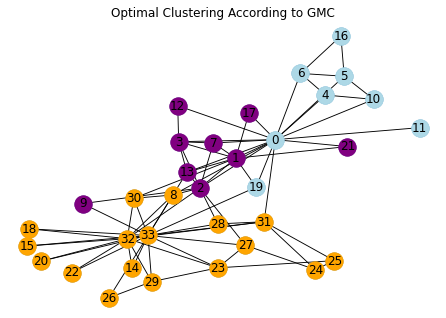

In [243]:
def plot_opt_groups():
    nx.draw(karate_nx, pos, edge_color='k',  with_labels=True,
         font_weight='light', node_size= 280, width= 0.9)

    #For each community list, draw the nodes, giving it a specific color.
    nx.draw_networkx_nodes(karate_nx, pos, nodelist=sorted(gmc_clusters[0]), node_color='orange')
    nx.draw_networkx_nodes(karate_nx, pos, nodelist=sorted(gmc_clusters[1]), node_color='purple')
    nx.draw_networkx_nodes(karate_nx, pos, nodelist=sorted(gmc_clusters[2]), node_color='lightblue')
    plt.title('Optimal Clustering According to GMC')
    plt.show()

plot_opt_groups()

For the next part, we want to find which communities the top 8 most central nodes (according to Degree Centrality and PageRank separately) belong in. The function below returns six lists, each list contains which of the top 8 nodes lies in said community.

In [244]:
def top_node_dist():

    # construct dictionary of node number and their rankings
    cd_dict = dict(zip(range(34), cd))
    cpr_dict = dict(zip(range(34), cpr))

    # order the dictionaries according to the rankings
    sorted_cd_dict = dict(sorted(cd_dict.items(), key=lambda x: x[1], reverse=True))
    sorted_cpr_dict = dict(sorted(cpr_dict.items(), key=lambda x: x[1], reverse=True))

    # compute the top 8 nodes
    top_cd_nodes = list(sorted_cd_dict.keys())[:8]
    top_cpr_nodes = list(sorted_cpr_dict.keys())[:8]

    # intialise lists
    group_one_cd = []
    group_two_cd = []
    group_three_cd = []

    group_one_cpr = []
    group_two_cpr = []
    group_three_cpr = []


    # find which clusters the nodes belong to, this is not the most efficient code but it is readable and doesnt need to be fast
    for i in range(8):
        if top_cd_nodes[i] in gmc_clusters[0]:
            group_one_cd.append(top_cd_nodes[i])
        elif top_cd_nodes[i] in gmc_clusters[1]:
            group_two_cd.append(top_cd_nodes[i])
        else:
            group_three_cd.append(top_cd_nodes[i])

        if top_cpr_nodes[i] in gmc_clusters[0]:
            group_one_cpr.append(top_cpr_nodes[i])
        elif top_cpr_nodes[i] in gmc_clusters[1]:
            group_two_cpr.append(top_cpr_nodes[i])
        else:
            group_three_cpr.append(top_cpr_nodes[i])

    return group_one_cd, group_two_cd, group_three_cd, group_one_cpr, group_two_cpr, group_three_cpr

Let's look at the results!

In [245]:
group_one_cd, group_two_cd, group_three_cd, group_one_cpr, group_two_cpr, group_three_cpr = top_node_dist()

print('Nodes in Community 1 (Degree): {}'.format(group_one_cd))
print('\n')
print('Nodes in Community 2 (Degree): {}'.format(group_two_cd))
print('\n')
print('Nodes in Community 3 (Degree): {}'.format(group_three_cd))
print('\n')
print('Nodes in Community 1 (PageRank): {}'.format(group_one_cpr))
print('\n')
print('Nodes in Community 2 (PageRank): {}'.format(group_two_cpr))
print('\n')
print('Nodes in Community 3 (PageRank): {}'.format(group_three_cpr))

Nodes in Community 1 (Degree): [33, 32, 31, 8]


Nodes in Community 2 (Degree): [2, 1, 3]


Nodes in Community 3 (Degree): [0]


Nodes in Community 1 (PageRank): [33, 32, 31, 23]


Nodes in Community 2 (PageRank): [2, 1, 3]


Nodes in Community 3 (PageRank): [0]


We have already establised the intrinsic similarity between the PageRank and Degree Centrality so it is no suprise that 7 out of the 8 top nodes are the same in both. The only diference is node 23 in PageRank and node 8 in Degree Centrality and, both of these lie in Community 1. We see the very connected nodes, (0, 1) and (32, 33) lie in communites together which suggests that they form central parts of separate (friendship) groups.

### 2.3.3

For this task, I had to implement the Adjusted Rand Index which is given by this formula
$$
ARI = \frac{\sum_{ij} {{n_{ij}}\choose{2}} - \left[ \sum_{i} {{a_{i}\choose {2}}} \sum_{j} {{b_{j}\choose {2}}}\right]/ {{n}\choose{2}}}{\frac{1}{2} \left[\sum_{i} {{a_{i}\choose {2}}} + \sum_{j} {{b_{j}\choose {2}}}\right] - \left[ \sum_{i} {{a_{i}\choose {2}}} \sum_{j} {{b_{j}\choose {2}}}\right]/{{n}\choose{2}}} = \frac{A-B}{C-B}
$$
further details can be found [here](https://en.wikipedia.org/wiki/Rand_index#:~:text=The%20adjusted%20Rand%20index%20is,specified%20by%20a%20random%20model).

To begin, I'll define an "n choose 2" function to simplify the code.

In [210]:
def choose_2(x):
    return (x*(x-1))/2

Now we can build the ARI function, its arguments are lists, containing the lists of nodes in each community/cluster.

In [211]:
def ARI(X, Y):
    # initialise values
    r = len(X)
    s = len(Y)
    n_mat = np.zeros((r, s))
    a_list = np.zeros(r)
    b_list = np.zeros(s)
    # build the contingency table
    for i in range(r):
        for j in range(s):
            n_mat[i, j] = len(list(set(X[i]) & set(Y[j])))
    
    # find the a_{i} and b_{j} values, store them in a vecotr
    a_vec = np.sum(n_mat, axis=1)
    b_vec = np.sum(n_mat, axis=0)

    # sum them
    asum = choose_2(a_vec).sum()
    bsum = choose_2(b_vec).sum()

    # compute component parts of the index
    A = choose_2(n_mat).sum()
    B = (asum*bsum)/choose_2(34)
    C = 1/2 * (asum + bsum)

    # compute index
    idx = (A-B)/(C-B)
    return idx

Now we want to quantify how similar the optimal clustering from 2.1.2 ($k=2$) and the clustering from 2.3.2. Before, we can do this, I need to compute which nodes are in each cluster for the implementation in 2.1.2

In [246]:
np.random.seed(1)
opt_labs, _, _ = kmeans(F, 2)

k_clusters = []
nodes = np.array([i for i in range(34)])
for l in np.unique(opt_labs):
    k_clusters.append(nodes[opt_labs==l])

Let's print these to get an idea of the clusterings.

In [247]:
print('Cluster 1: \n {}'.format(k_clusters[0]))
print('\n')
print('Cluster 2: \n {}'.format(k_clusters[1]))

Cluster 1: 
 [ 1  4  6  8 10 11 12 17 18 21 22 26 29 31 33]


Cluster 2: 
 [ 0  2  3  5  7  9 13 14 15 16 19 20 23 24 25 27 28 30 32]


Now, lets compute the ARI.

In [248]:
ari_kmeans_gmc = ARI(gmc_clusters, k_clusters)
print('The ARI between our clusters in 2.1.2 and 2.3.2 is {}'.format(ari_kmeans_gmc))

The ARI between our clusters in 2.1.2 and 2.3.2 is -0.031487014479429976


This value is extremely small which demonstrates that clusters are very dissimilar. However, this is to be expected: one set of clusters is based on traits that people have and one is based on friendships between people. There is a tenuous link, particularly at social clubs, between personality traits and friendships, so this results is unsurprising.

Let's check the real results for comparison.

In [249]:
ground_truth = pd.read_csv('ground_truth_karate_club.csv', sep=',')

In [250]:
ground_truth = ground_truth.values

In [251]:
print(ground_truth)

[[0 'Mr. Hi']
 [1 'Mr. Hi']
 [2 'Mr. Hi']
 [3 'Mr. Hi']
 [4 'Mr. Hi']
 [5 'Mr. Hi']
 [6 'Mr. Hi']
 [7 'Mr. Hi']
 [8 'Mr. Hi']
 [9 'Officer']
 [10 'Mr. Hi']
 [11 'Mr. Hi']
 [12 'Mr. Hi']
 [13 'Mr. Hi']
 [14 'Officer']
 [15 'Officer']
 [16 'Mr. Hi']
 [17 'Mr. Hi']
 [18 'Officer']
 [19 'Mr. Hi']
 [20 'Officer']
 [21 'Mr. Hi']
 [22 'Officer']
 [23 'Officer']
 [24 'Officer']
 [25 'Officer']
 [26 'Officer']
 [27 'Officer']
 [28 'Officer']
 [29 'Officer']
 [30 'Officer']
 [31 'Officer']
 [32 'Officer']
 [33 'Officer']]


We see there are two classes, let's find which nodes are in which class.

In [252]:
def truth_classes():
    truth_groups = []
    truth_one = []
    truth_two = []
    for i in range(ground_truth.shape[0]):
        if ground_truth[i, 1] == 'Mr. Hi':
            truth_one.append(i)
        else:
            truth_two.append(i)
    
    truth_groups.append(truth_one)
    truth_groups.append(truth_two)
    return truth_groups

truth_groups = truth_classes()

Now let's compute the ARI between the truth classes and our other two optimal models.

In [253]:
ari_kmeans_truth = ARI(truth_groups, k_clusters)
ari_gmc_truth = ARI(truth_groups, node_groups)

print('The ARI between our clusters in 2.1.2 and the truth is {}'.format(ari_kmeans_truth))
print('The ARI between our clusters in 2.3.2 and the truth is {}'.format(ari_gmc_truth))

The ARI between our clusters in 2.1.2 and the truth is 0.0012970168612192327
The ARI between our clusters in 2.3.2 and the truth is 0.5684394071490846


These results are really interesting: they confirm our analysis throughout. In this case, the kmeans algorithm is simply not suitable as the ARI values when it is involved are -0.03 and 0.001. There are several potential factors, the first is that the data is about traits and that does not reflect who people are friends with or, it could be because the dimension of the data set is simply too big.

However, we see our optimal clusters given by GMC is reasonably close to the ground truth, especially considering the sets had different sizes - we have an ARI value of 0.568. This could be for several reasons: either the algorithm is better suited to this dataset compared with $k$-means clustering or, it could be because this data set describes friendships which are far more likely to be a good predictor of the groups of people we have.